<a href="https://colab.research.google.com/github/raihanewubd/MLSummer24/blob/main/Trasformer_Model_with_Keras_(IMDB_Dataset).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Setup

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

Implement a Transformer block as a layer

In [ ]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

Implement embedding layer
Two seperate embedding layers, one for tokens, one for token index (positions).

In [ ]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

Download and prepare dataset

In [ ]:
vocab_size = 20000  # Only consider the top 20k words
maxlen = 200  # Only consider the first 200 words of each movie review
(x_train, y_train), (x_val, y_val) = keras.datasets.imdb.load_data(num_words=vocab_size)
print(len(x_train), "Training sequences")
print(len(x_val), "Validation sequences")
x_train = keras.utils.pad_sequences(x_train, maxlen=maxlen)
x_val = keras.utils.pad_sequences(x_val, maxlen=maxlen)

25000 Training sequences
25000 Validation sequences


Create classifier model using transformer layer
Transformer layer outputs one vector for each time step of our input sequence. Here, we take the mean across all time steps and use a feed forward network on top of it to classify text.

In [ ]:
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(2, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

Train and Evaluate

In [ ]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
history = model.fit(
    x_train, y_train, batch_size=32, epochs=3, validation_data=(x_val, y_val)
)

Epoch 1/4
782/782 [==============================] - 83s 102ms/step - loss: 0.4163 - accuracy: 0.7910 - val_loss: 0.2883 - val_accuracy: 0.8765
Epoch 2/4
782/782 [==============================] - 88s 112ms/step - loss: 0.2013 - accuracy: 0.9231 - val_loss: 0.3044 - val_accuracy: 0.8736
Epoch 3/4
782/782 [==============================] - 74s 94ms/step - loss: 0.1337 - accuracy: 0.9513 - val_loss: 0.3737 - val_accuracy: 0.8590
Epoch 4/4
782/782 [==============================] - 79s 101ms/step - loss: 0.0844 - accuracy: 0.9720 - val_loss: 0.4423 - val_accuracy: 0.8560


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


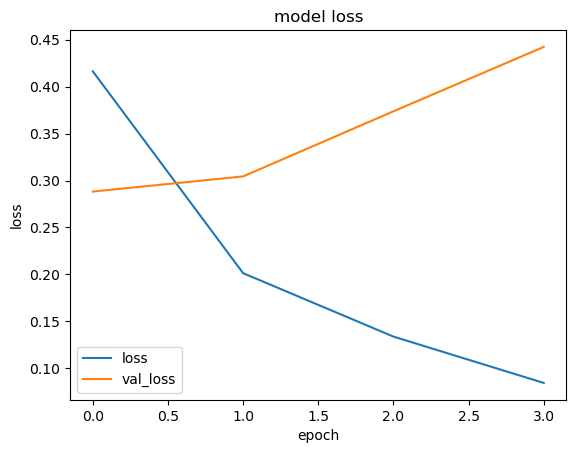

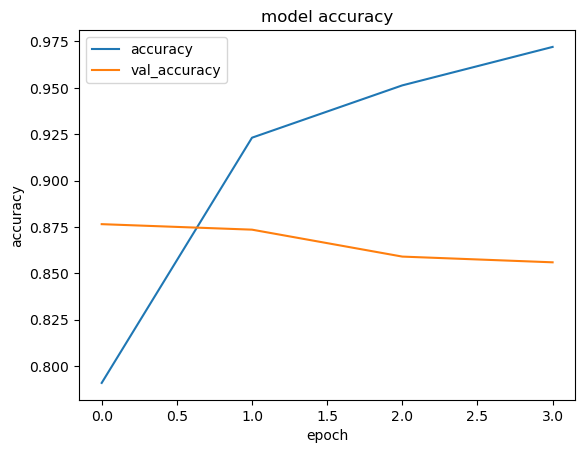

In [ ]:
import matplotlib.pyplot as plt

print(history.history.keys())
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'])
plt.show()

accuracy = history.history['accuracy']
val_accuracy= history.history['val_accuracy']
plt.plot(accuracy)
plt.plot(val_accuracy)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

782/782 [==============================] - 29s 37ms/step


 Classification report : 

               precision    recall  f1-score   support

           0       0.86      0.85      0.86     12500
           1       0.85      0.86      0.86     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000



 Confusion Matrix : 

 [[10631  1869]
 [ 1732 10768]]


 Model Accuracy Score :    0.85596


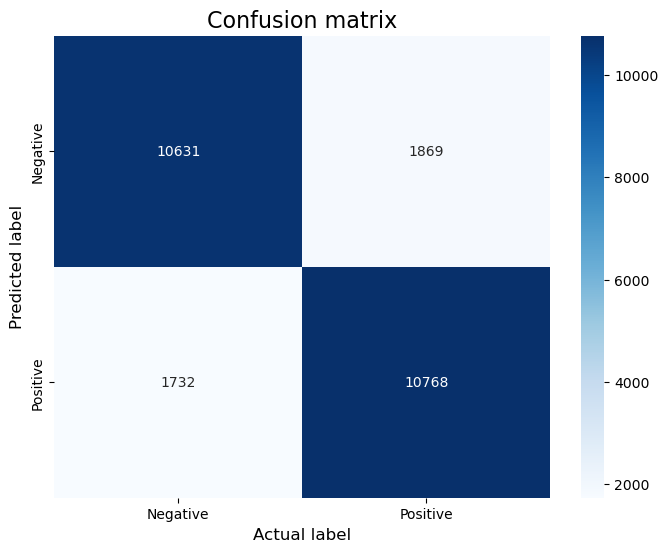

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
import seaborn as sns

y_pred = model.predict(x_val)
y_pred = np.argmax(y_pred, axis=1)
#test_la = np.argmax(np.array(y_val),axis=1)

cm = confusion_matrix(y_val, y_pred)

print("\n\n Classification report : \n\n",classification_report(y_val, y_pred))
print("\n\n Confusion Matrix : \n\n",cm)
print("\n\n Model Accuracy Score :   ",accuracy_score(y_val, y_pred))


plt.figure(figsize=(8,6))

cm = confusion_matrix(y_val, y_pred)
sentiment_classes = ['Negative', 'Positive']
sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d',
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
plt.title('Confusion matrix', fontsize=16)
plt.xlabel('Actual label', fontsize=12)
plt.ylabel('Predicted label', fontsize=12)
plt.show()


In [ ]:
!pip install pydot
!pip install graphviz

[0 1 1 ... 0 0 1]


In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
